**Data Preparation**

In [1]:
# importing required libraries
import numpy as np
import pandas as pd 
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [2]:
# dataset doesn't have column names, so we have to provide it
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

In [3]:
# importing dataset
data = pd.read_csv('IDS.csv',names=col_names, header=None)

In [4]:
# print dataset
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune


In [5]:

data.shape

(125973, 42)

In [6]:
# descriptive statistics of dataset
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
print('Number of Rows (Samples): %s' % str((data.shape[0])))
print('Number of Columns (Features): %s' % str((data.shape[1])))

Number of Rows (Samples): 125973
Number of Columns (Features): 42


In [8]:
data.head(4)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal


In [9]:
# number of attack labels 
data['label'].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

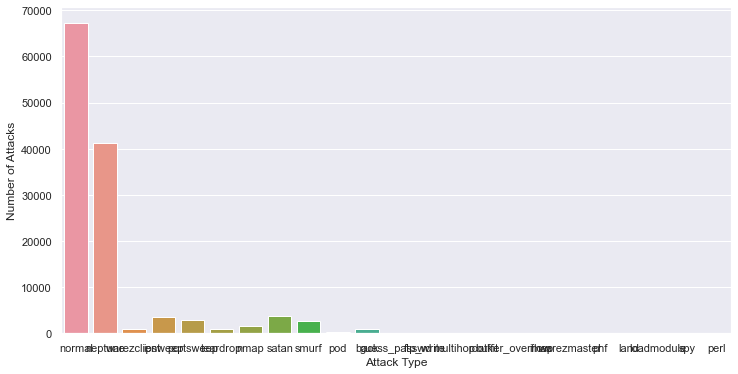

In [10]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='label', data=data)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.show()

In [11]:
# changing attack labels to their respective attack class
def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [12]:
# calling change_label() function
change_label(data)

In [13]:
# distribution of attack classes
data.label.value_counts()

normal    67343
Dos       45927
Probe     11656
R2L         995
U2R          52
Name: label, dtype: int64

**Data Normalization**

In [14]:
# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [15]:
# selecting numeric attributes columns from data
numeric_col = data.select_dtypes(include='number').columns

In [16]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

In [17]:
# data before normalization
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [18]:
# calling the normalization() function
#data = normalization(data.copy(),numeric_col)

In [19]:
# data after normalization
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


**One-hot-encoding**

In [20]:
# selecting categorical data attributes
cat_col = ['protocol_type','service','flag']

In [21]:
# creating a dataframe with only categorical attributes
categorical = data[cat_col]
categorical

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF
...,...,...,...
125968,tcp,private,S0
125969,udp,private,SF
125970,tcp,smtp,SF
125971,tcp,klogin,S0


In [22]:
# one-hot-encoding categorical attributes using pandas.get_dummies() function
categorical = pd.get_dummies(categorical,columns=cat_col)
categorical.to_csv("catgorical.csv",index=False)
categorical.head()


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


**Binary Classification**

In [23]:
# changing attack labels into two categories 'normal' and 'abnormal'
bin_label = pd.DataFrame(data.label.map(lambda x:'normal' if x=='normal' else 'abnormal'))

In [24]:
# creating a dataframe with binary labels (normal,abnormal)
bin_data = data.copy()
bin_data['label'] = bin_label

In [25]:
# label encoding (0,1) binary labels (abnormal,normal)
le1 = preprocessing.LabelEncoder()
enc_label = bin_label.apply(le1.fit_transform)
bin_data['intrusion'] = enc_label

In [26]:
le1.classes_

array(['abnormal', 'normal'], dtype=object)

In [27]:
np.save("le1_classes.npy",le1.classes_,allow_pickle=True)

In [28]:
# dataset with binary labels and label encoded column
bin_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,intrusion
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,1
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,1
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,abnormal,0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,1
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,1


In [29]:
# one-hot-encoding attack label
bin_data = pd.get_dummies(bin_data,columns=['label'],prefix="",prefix_sep="") 
bin_data['label'] = bin_label
bin_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,abnormal,normal,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,1,0,1,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,1,0,1,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,abnormal
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,1,0,1,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,abnormal
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,1,0,1,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,1,0,1,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,abnormal


In [30]:
# importing library for plotting
import matplotlib.pyplot as plt

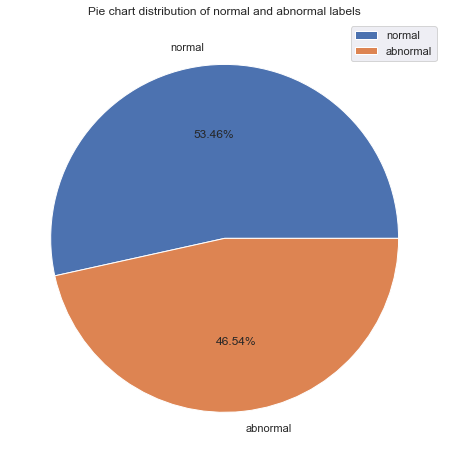

In [31]:
# pie chart distribution of normal and abnormal labels
plt.figure(figsize=(8,8))
plt.pie(bin_data.label.value_counts(),labels=bin_data.label.unique(),autopct='%0.2f%%')
plt.title("Pie chart distribution of normal and abnormal labels")
plt.legend()
#plt.savefig('plots/Pie_chart_binary.png')
plt.show()

**Multi-class Classification**

In [32]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = data.copy()
multi_label = pd.DataFrame(multi_data.label)

In [33]:
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,Dos
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,Dos


In [34]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label

In [35]:
le2.classes_

array(['Dos', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

In [36]:
np.save("le2_classes.npy",le2.classes_,allow_pickle=True)

In [37]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['label'],prefix="",prefix_sep="") 
multi_data['label'] = multi_label
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,Dos,Probe,R2L,U2R,normal,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.00,0.05,0.00,4,0,0,0,0,1,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.00,0.00,4,0,0,0,0,1,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,1,0,0,0,0,Dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.01,0.00,0.01,4,0,0,0,0,1,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,4,0,0,0,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,1,0,0,0,0,Dos
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.00,0.00,0.00,4,0,0,0,0,1,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.01,0.00,4,0,0,0,0,1,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,1.00,0.00,0.00,0,1,0,0,0,0,Dos


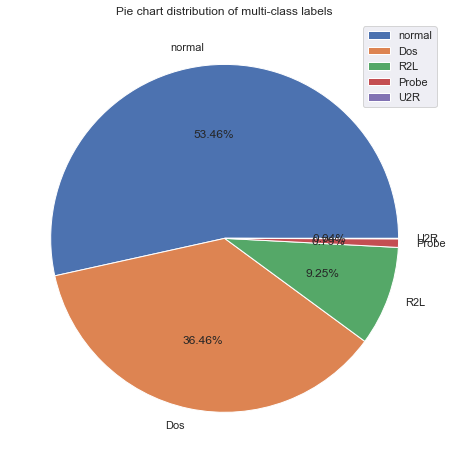

In [38]:
# pie chart distribution of multi-class labels
plt.figure(figsize=(8,8))
plt.pie(multi_data.label.value_counts(),labels=multi_data.label.unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend()
#plt.savefig('plots/Pie_chart_multi.png')
plt.show()

**Feature selection and Extraction**

In [39]:
bin_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion,abnormal,normal,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.00,0.00,0.00,0.05,0.00,1,0,1,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.00,0.00,1,0,1,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,abnormal
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.00,0.01,1,0,1,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,abnormal
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.01,0.00,0.00,0.00,0.00,0.00,1,0,1,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.00,0.00,0.72,0.00,0.01,0.00,1,0,1,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.00,0.00,0,1,0,abnormal


In [40]:
# creating a dataframe with only numeric attributes of binary class dataset and encoded label attribute 
numeric_bin = bin_data[numeric_col]
numeric_bin['intrusion'] = bin_data['intrusion']

C:\Users\DELL\AppData\Local\Temp\ipykernel_18136\1004089906.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
numeric_bin

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion
0,0,491,0,0,0,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,146,0,0,0,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,0,0,0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,232,8153,0,0,0,0,0,1,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,199,420,0,0,0,0,0,1,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,0,0,0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0
125969,8,105,145,0,0,0,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,1
125970,0,2231,384,0,0,0,0,0,1,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,1
125971,0,0,0,0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0


In [42]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr= numeric_bin.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

count                       0.576444
srv_serror_rate             0.648289
serror_rate                 0.650652
dst_host_serror_rate        0.651842
dst_host_srv_serror_rate    0.654985
logged_in                   0.690171
dst_host_same_srv_rate      0.693803
dst_host_srv_count          0.722535
same_srv_rate               0.751913
intrusion                   1.000000
Name: intrusion, dtype: float64

In [43]:
# selecting attributes found by using pearson correlation coefficient
numeric_bin = bin_data[['count','srv_serror_rate','serror_rate','dst_host_serror_rate','dst_host_srv_serror_rate',
                         'logged_in','dst_host_same_srv_rate','dst_host_srv_count','same_srv_rate']]

In [44]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_bin = numeric_bin.join(categorical)
# then joining encoded, one-hot-encoded, and original attack label attribute
bin_data = numeric_bin.join(bin_data[['intrusion','abnormal','normal','label']])
bin_data

,count,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_srv_serror_rate,logged_in,dst_host_same_srv_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,intrusion,abnormal,normal,label
0,2,0.0,0.0,0.00,0.00,0,0.17,25,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
1,13,0.0,0.0,0.00,0.00,0,0.00,1,0.08,0,...,0,0,0,0,1,0,1,0,1,normal
2,123,1.0,1.0,1.00,1.00,0,0.10,26,0.05,0,...,1,0,0,0,0,0,0,1,0,abnormal
3,5,0.2,0.2,0.03,0.01,1,1.00,255,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
4,30,0.0,0.0,0.00,0.00,1,1.00,255,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,184,1.0,1.0,1.00,1.00,0,0.10,25,0.14,0,...,1,0,0,0,0,0,0,1,0,abnormal
125969,2,0.0,0.0,0.00,0.00,0,0.96,244,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
125970,1,0.0,0.0,0.72,0.00,1,0.12,30,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
125971,144,1.0,1.0,1.00,1.00,0,0.03,8,0.06,0,...,1,0,0,0,0,0,0,1,0,abnormal


In [45]:
# saving final dataset to disk
#bin_data.to_csv("./datasets/bin_data.csv")
# final dataset for binary classification
bin_data

,count,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_srv_serror_rate,logged_in,dst_host_same_srv_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,intrusion,abnormal,normal,label
0,2,0.0,0.0,0.00,0.00,0,0.17,25,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
1,13,0.0,0.0,0.00,0.00,0,0.00,1,0.08,0,...,0,0,0,0,1,0,1,0,1,normal
2,123,1.0,1.0,1.00,1.00,0,0.10,26,0.05,0,...,1,0,0,0,0,0,0,1,0,abnormal
3,5,0.2,0.2,0.03,0.01,1,1.00,255,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
4,30,0.0,0.0,0.00,0.00,1,1.00,255,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,184,1.0,1.0,1.00,1.00,0,0.10,25,0.14,0,...,1,0,0,0,0,0,0,1,0,abnormal
125969,2,0.0,0.0,0.00,0.00,0,0.96,244,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
125970,1,0.0,0.0,0.72,0.00,1,0.12,30,1.00,0,...,0,0,0,0,1,0,1,0,1,normal
125971,144,1.0,1.0,1.00,1.00,0,0.03,8,0.06,0,...,1,0,0,0,0,0,0,1,0,abnormal


In [46]:
# creating a dataframe with only numeric attributes of multi-class dataset and encoded label attribute 
numeric_multi = multi_data[numeric_col]
numeric_multi['intrusion'] = multi_data['intrusion']

C:\Users\DELL\AppData\Local\Temp\ipykernel_18136\2873760033.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
# finding the attributes which have more than 0.5 correlation with encoded attack label attribute 
corr = numeric_multi.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

count                       0.613251
logged_in                   0.693770
srv_serror_rate             0.710852
serror_rate                 0.712861
dst_host_serror_rate        0.714247
dst_host_same_srv_rate      0.716820
dst_host_srv_serror_rate    0.717387
dst_host_srv_count          0.718579
same_srv_rate               0.798358
intrusion                   1.000000
Name: intrusion, dtype: float64

In [48]:
# selecting attributes found by using pearson correlation coefficient
numeric_multi = multi_data[['count','logged_in','srv_serror_rate','serror_rate','dst_host_serror_rate',
                        'dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_srv_count','same_srv_rate']]

In [49]:
# joining the selected attribute with the one-hot-encoded categorical dataframe
numeric_multi = numeric_multi.join(categorical)
# then joining encoded, one-hot-encoded, and original attack label attribute
multi_data = numeric_multi.join(multi_data[['intrusion','Dos','Probe','R2L','U2R','normal','label']])

In [50]:
numeric_multi

,count,logged_in,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,2,0,0.0,0.0,0.00,0.17,0.00,25,1.00,0,...,0,0,0,0,0,0,0,0,1,0
1,13,0,0.0,0.0,0.00,0.00,0.00,1,0.08,0,...,0,0,0,0,0,0,0,0,1,0
2,123,0,1.0,1.0,1.00,0.10,1.00,26,0.05,0,...,0,0,0,0,1,0,0,0,0,0
3,5,1,0.2,0.2,0.03,1.00,0.01,255,1.00,0,...,0,0,0,0,0,0,0,0,1,0
4,30,1,0.0,0.0,0.00,1.00,0.00,255,1.00,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,184,0,1.0,1.0,1.00,0.10,1.00,25,0.14,0,...,0,0,0,0,1,0,0,0,0,0
125969,2,0,0.0,0.0,0.00,0.96,0.00,244,1.00,0,...,0,0,0,0,0,0,0,0,1,0
125970,1,1,0.0,0.0,0.72,0.12,0.00,30,1.00,0,...,0,0,0,0,0,0,0,0,1,0
125971,144,0,1.0,1.0,1.00,0.03,1.00,8,0.06,0,...,0,0,0,0,1,0,0,0,0,0


In [51]:
print(multi_data)

        count  logged_in  srv_serror_rate  serror_rate  dst_host_serror_rate  \
0           2          0              0.0          0.0                  0.00   
1          13          0              0.0          0.0                  0.00   
2         123          0              1.0          1.0                  1.00   
3           5          1              0.2          0.2                  0.03   
4          30          1              0.0          0.0                  0.00   
...       ...        ...              ...          ...                   ...   
125968    184          0              1.0          1.0                  1.00   
125969      2          0              0.0          0.0                  0.00   
125970      1          1              0.0          0.0                  0.72   
125971    144          0              1.0          1.0                  1.00   
125972      1          1              0.0          0.0                  0.00   

        dst_host_same_srv_rate  dst_hos

**Artificial Neural Network**

In [52]:
X = multi_data.iloc[:,0:93]  # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = multi_data[['Dos','normal','Probe','R2L','U2R']] # target attributes

In [53]:
X

,count,logged_in,srv_serror_rate,serror_rate,dst_host_serror_rate,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_srv_count,same_srv_rate,protocol_type_icmp,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,2,0,0.0,0.0,0.00,0.17,0.00,25,1.00,0,...,0,0,0,0,0,0,0,0,1,0
1,13,0,0.0,0.0,0.00,0.00,0.00,1,0.08,0,...,0,0,0,0,0,0,0,0,1,0
2,123,0,1.0,1.0,1.00,0.10,1.00,26,0.05,0,...,0,0,0,0,1,0,0,0,0,0
3,5,1,0.2,0.2,0.03,1.00,0.01,255,1.00,0,...,0,0,0,0,0,0,0,0,1,0
4,30,1,0.0,0.0,0.00,1.00,0.00,255,1.00,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,184,0,1.0,1.0,1.00,0.10,1.00,25,0.14,0,...,0,0,0,0,1,0,0,0,0,0
125969,2,0,0.0,0.0,0.00,0.96,0.00,244,1.00,0,...,0,0,0,0,0,0,0,0,1,0
125970,1,1,0.0,0.0,0.72,0.12,0.00,30,1.00,0,...,0,0,0,0,0,0,0,0,1,0
125971,144,0,1.0,1.0,1.00,0.03,1.00,8,0.06,0,...,0,0,0,0,1,0,0,0,0,0


In [54]:
# splitting the dataset 75% for training and 25% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

In [55]:
from keras.models import Sequential
from keras.layers import Activation, Dense
mlp = Sequential() # initializing model
# input layer and first layer with 50 neurons
mlp.add(Dense(units=50, input_dim=X_train.shape[1], activation='relu'))
# output layer with softmax activation
mlp.add(Dense(units=5,activation='softmax'))

**Genetic Algorithm (search-based optimization technique)**

In [56]:
#!sys.path.append('/path/to/your/model/modules/')
#!pip install snorkel
#!pip3 install pygad
import pandas as pd
import random
from tabulate import tabulate

In [57]:
def __init__(self, debug, mutation, attack, save_model, customModel=None):
        self.DEBUG = debug
        self.MUTATION_PERCENTAGE = mutation
        self.ATTACK = self.select_attack(attack)
        print("Seed attack for algorithm run")
        print(self.ATTACK)

        #Get our model
        print("Initialising Model")
        self.model_obj = Model(False, attack, save_model)
        self.model = self.model_obj.generate_model()

   # def select_attack(self, attack_type):
        test_df = pd.read_csv("IDS,csv", header=None, names=data_headers)
        #Pick a random attack of attack_type from here
        attacks = test_df.loc[test_df['attack'] == attack_type]
        sample_attack = attacks.sample(1)
        return sample_attack.values[0]
def getModel(self):
        return self.model

def getSeedAttack(self):
        return self.ATTACK

In [58]:
#Function to test if a feature variable is valid for the algorithm execution
def validId(self, idx):
        if (idx == 1 or idx == 2 or idx == 3 or idx == 6 or idx == 41 or idx == 42):
            return False
        else:
            return True

In [59]:
#Function used to evaluate a single sample on the model
def evaluate_sample(self, model, sample):
        sample_df = pd.DataFrame([sample], columns=data_headers)
        dropped = sample_df.drop(["unknown", "attack", "protocol_type", "service", "flag"], axis=1)
        #encoded_df = pd.get_dummies(dropped, columns=["protocol_type", "service", "flag"])
        pred = model.predict(dropped)
        return (pred)

In [60]:
#Function to generate some mutation to produce genetic drift in the population
def add_mutation(self, sample):
        for idx, val in enumerate(sample):
            if (not self.validId(idx)):
#Skip protocol type, service, flag, land and attack feature variables
                continue
            
#Mutate each gene or feature variable with 5% change
            rand = random.randint(0, 100)
            if (rand <= self.MUTATION_PERCENTAGE and self.variableCanMutate(sample, idx)):
                #Mutate by picking from a random index within allowable range
                max_range = attack_generation_labels[data_headers[idx]][-1]
                index = random.randint(0, max_range)
                new_value = attack_generation_labels[data_headers[idx]][index]
                sample[idx] = new_value  

        return sample 

In [61]:
#Prints out information for  the current population
def display_population_statistics(self, population):
        print("FITTEST SAMPLE: "  + str(population[-1]['fitness']))
        print("WEAKEST SAMPLE: "  + str(population[0]['fitness']))
        num_attacks = 0
        for sample in population:
            if (sample['attack']):
                num_attacks += 1
        print("NUMBER OF SAMPLE ATTACKS: " + str(num_attacks))
        print(" ")

#Prints out the current population
def display_population(self, population):
        #Output to a html table
        table = tabulate(population, tablefmt="html", headers=list(attack_generation_labels.keys()))
        table_file = open("final_samples.html","w")
        table_file.write(table)
        table_file.close()
        print("POPULATION")
        for sample in population:
            print(sample)

In [62]:
 #Function to run the algorithm
    #model = the model used to evaluate attack samples
    #initial_parent = the initial genetic parent used to breed offspring
    #iterations = the number of iterations / generations to breed
    #offspring_number = the number of offspring to breed per generation
    #fittest_num = the number of offspring to pick to move through to the next generation
def run_algorithm(self, iterations, offspring_number, fittest_num):
        #Breed initial population
        print("Breeding Initial Population")
        population = []
        for i in range(offspring_number):
                population.append(self.generate_offspring(self.ATTACK, self.ATTACK))

        print("Running Genetic Algorithm")
        for j in range(iterations):
            print("GENERATION: " + str(j))
            offspring = []
            for index in range(offspring_number):
                parent1 = random.randint(0, len(population) -1)
                parent2 = random.randint(0, len(population) -1)
                offspring.append(self.generate_offspring(population[parent1], population[parent2]))
            
            #Place offspring in population
            population.extend(offspring)

            #Evaluate the fittest_num samples to go through to next population
            fittest_samples = []
            for sample in population:
                sample_fitness = self.fitness(self.model, self.ATTACK, sample)
                is_attack = self.evaluate_sample(self.model, sample) #whether the IDS classified this as an attack or not
                fittest_samples.append({'fitness': sample_fitness, 'sample': sample, 'attack': is_attack})
            fittest_samples.sort(key=self.key_extractor)
            #Trim population if too large
            if (len(fittest_samples) > fittest_num):
                population = fittest_samples[len(fittest_samples) - fittest_num: ]
            
            if self.DEBUG:
                self.display_population_statistics(population)
            raw_population = population
            population = list(map(self.sample_extractor, population))

        self.display_population(population)
        return raw_population

In [63]:
# defining loss function, optimizer, metrics and then compiling model
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [64]:
# summary of model layers
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                4700      
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 4,955
Trainable params: 4,955
Non-trainable params: 0
_________________________________________________________________


In [65]:
# training the model on training dataset
history = mlp.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
16/16 [==============================] - 3s 70ms/step - loss: 18.6659 - accuracy: 0.0725 - val_loss: 6.6818 - val_accuracy: 0.1573
Epoch 2/100
16/16 [==============================] - 1s 32ms/step - loss: 2.5332 - accuracy: 0.6125 - val_loss: 0.8777 - val_accuracy: 0.8451
Epoch 3/100
16/16 [==============================] - 0s 25ms/step - loss: 0.9794 - accuracy: 0.8446 - val_loss: 0.8336 - val_accuracy: 0.8531
Epoch 4/100
16/16 [==============================] - 0s 20ms/step - loss: 0.6616 - accuracy: 0.8635 - val_loss: 0.4475 - val_accuracy: 0.8770
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.4108 - accuracy: 0.8943 - val_loss: 0.3781 - val_accuracy: 0.8964
Epoch 6/100
16/16 [==============================] - 0s 13ms/step - loss: 0.3641 - accuracy: 0.9030 - val_loss: 0.3444 - val_accuracy: 0.9218
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.3322 - accuracy: 0.9163 - val_loss: 0.3197 - val_accuracy: 0.9177
Epoch

16/16 [==============================] - 0s 27ms/step - loss: 0.0962 - accuracy: 0.9689 - val_loss: 0.1001 - val_accuracy: 0.9671
Epoch 59/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0959 - accuracy: 0.9689 - val_loss: 0.1004 - val_accuracy: 0.9672
Epoch 60/100
16/16 [==============================] - 0s 22ms/step - loss: 0.0952 - accuracy: 0.9693 - val_loss: 0.0996 - val_accuracy: 0.9673
Epoch 61/100
16/16 [==============================] - 0s 25ms/step - loss: 0.0946 - accuracy: 0.9694 - val_loss: 0.0986 - val_accuracy: 0.9676
Epoch 62/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0941 - accuracy: 0.9692 - val_loss: 0.0980 - val_accuracy: 0.9672
Epoch 63/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0931 - accuracy: 0.9696 - val_loss: 0.0971 - val_accuracy: 0.9678
Epoch 64/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0928 - accuracy: 0.9698 - val_loss: 0.0973 - val_accuracy: 0.9681
Epoch 65/100

In [66]:
# defining loss function, optimizer, metrics and then compiling model
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
# predicting target attribute on testing dataset
test_results = mlp.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

985/985 [==============================] - 3s 3ms/step - loss: 0.0833 - accuracy: 0.9751
Test results - Loss: 0.08333363384008408 - Accuracy: 97.51063585281372%


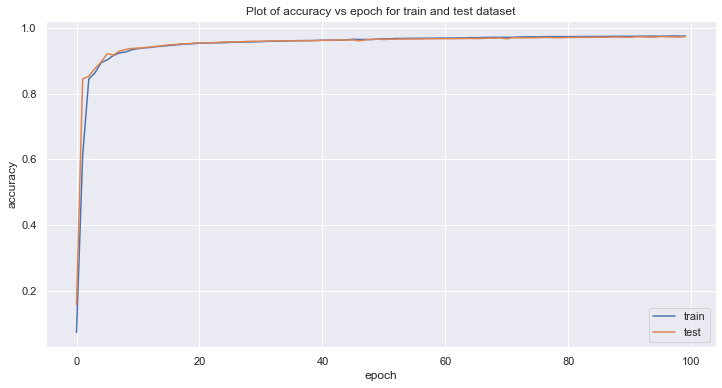

In [68]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
#plt.savefig('plots/mlp_multi_accuracy.png')
plt.show()

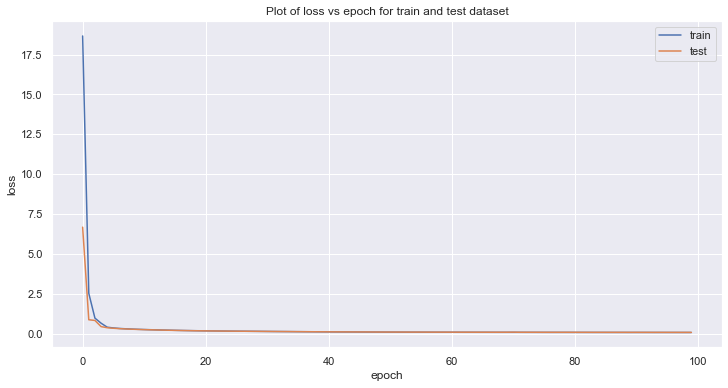

In [69]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.savefig('plots/mlp_multi_loss.png')
plt.show()

In [70]:
n_classes = len(le2.classes_)
n_classes

5

In [71]:
y_pred = mlp.predict(X_test)

985/985 [==============================] - 3s 3ms/step


In [72]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
fpr_mlp = dict()
tpr_mlp = dict()
roc_auc_mlp = dict()
for i in range(n_classes):
    fpr_mlp[i], tpr_mlp[i], _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
    roc_auc_mlp[i] = auc(fpr_mlp[i], tpr_mlp[i])

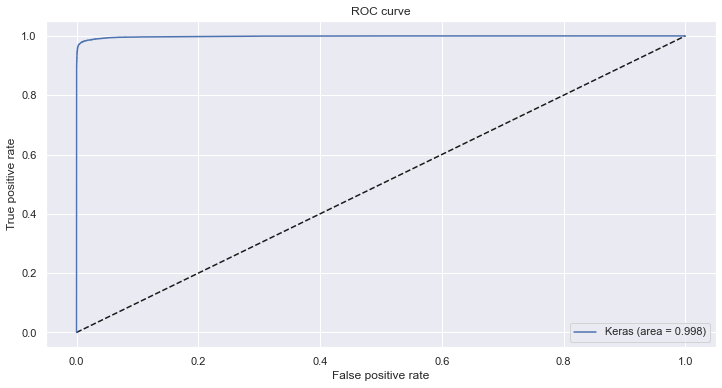

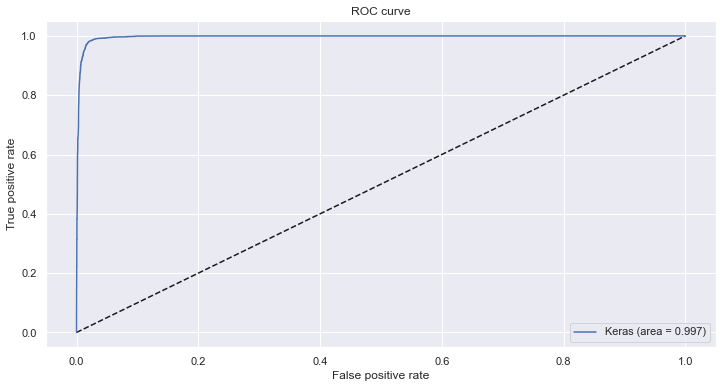

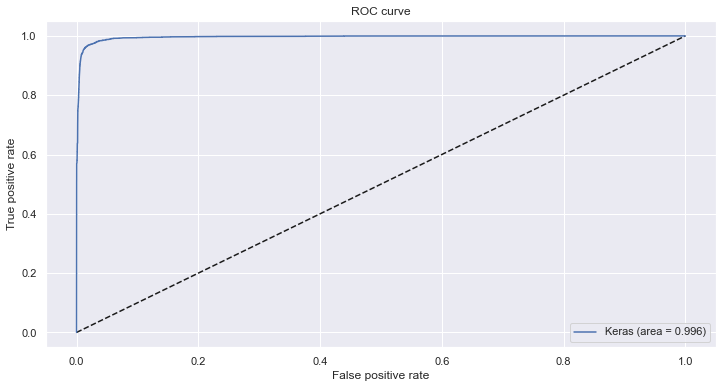

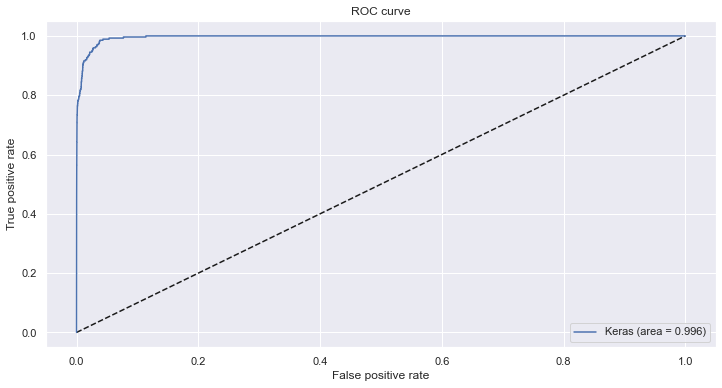

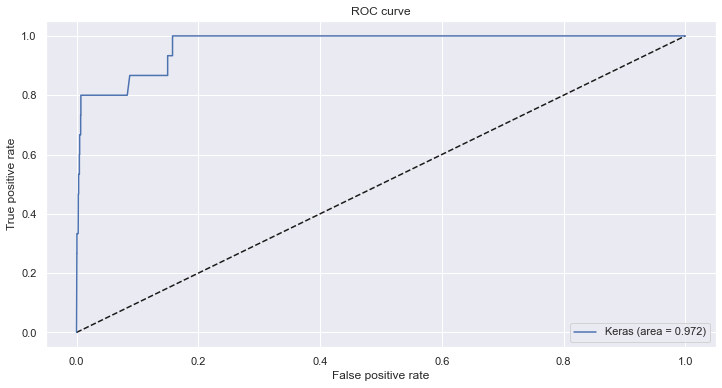

In [73]:
for i in range(n_classes):
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_mlp[i], tpr_mlp[i], label='Keras (area = {:.3f})'.format(roc_auc_mlp[i]))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.savefig('plots/mlp_multi_roc'+str(i)+'.png')
  plt.show()

In [74]:
pred = mlp.predict(X_test)

985/985 [==============================] - 2s 2ms/step


In [75]:
for j in range(0,pred.shape[1]):
  for i in range(0,pred.shape[0]):
    pred[i][j] = int(round(pred[i][j]))

In [76]:
y_test.columns

Index(['Dos', 'normal', 'Probe', 'R2L', 'U2R'], dtype='object')

In [77]:
pred_df = pd.DataFrame(pred,columns=y_test.columns)

In [78]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score
    
print("Recall Score - ",recall_score(y_test,pred_df.astype('uint8'),average='micro'))
print("F1 Score - ",f1_score(y_test,pred_df.astype('uint8'),average='micro'))
print("Precision Score - ",precision_score(y_test,pred_df.astype('uint8'),average='micro'))

Recall Score -  0.9734235092398552
F1 Score -  0.9748938673620275
Precision Score -  0.9763686741615974


In [79]:
y_train

,Dos,normal,Probe,R2L,U2R
69124,1,0,0,0,0
20983,1,0,0,0,0
113664,1,0,0,0,0
110444,0,1,0,0,0
75941,0,1,0,0,0
...,...,...,...,...,...
119879,1,0,0,0,0
103694,1,0,0,0,0
860,1,0,0,0,0
15795,0,1,0,0,0


In [81]:
mlp.save('mlpmodel.h5')